# Classical Multiclass Model Training on Code Smell Metrics
This notebook trains a classical machine learning model to classify code smells into four types based on CSQA-derived metrics: **Long Method**, **Large/God Class**, **Feature Envy**, and **Data Class**.
We use balanced and preprocessed data via SMOTE (Synthetic Minority Oversampling Technique) and evaluate the model's performance for comparison with transformer-based models in the main study.

## Load and Prepare the Balanced Multiclass Dataset
We use the `prepare_multiclass_dataset()` function to:
- read and clean CSQA merged metrics;
- map smell names to integer classes;
- balance the dataset using SMOTE;
- scale the features.

In [1]:
from src.data_processing.csqa_multiclass_prepare import prepare_multiclass_dataset

X_train, X_test, y_train, y_test, scaler = prepare_multiclass_dataset("../data/processed/csqa_merged_metrics.csv",
                                                                      "../data/processed/csqa_multiclass_balanced.csv",
                                                                      0.2,
                                                                      42)

✅ Saved balanced multiclass dataset: ../data/processed/csqa_multiclass_balanced.csv
Class distribution after SMOTE:
label
1    1985198
2    1985198
4    1985198
3    1985198
Name: count, dtype: int64



## Classical Multilabel Training with SmellyCode++ and CSQA Dataset

This section demonstrates how to:
- Prepare a unified dataset by merging SmellyCode++ and CSQA metric columns.
- Normalize numerical features using StandardScaler.
- Train and evaluate two classical multilabel classifiers: RandomForest and XGBoost.
- Save the resulting models and scalers using joblib for later inference.


### Load Datasets
We load:
- SmellyCode++ (raw metrics + labels)
- CSQA metrics to detect common overlapping metrics

In [7]:
import pandas as pd
df_smelly = pd.read_csv("../data/raw/52714583_multi-smell-dataset-v1_2.csv")
df_csqa = pd.read_csv("../data/processed/csqa_multiclass_balanced.csv")

### Determine Common Metrics
Find intersection of metric columns between datasets for fair merging.

In [8]:
column_mapping = {
    "Logical Lines": "LOC",
    "Cyclomatic Complexity": "CYCLO",
    "Distinct Operators": "NumberOfOperatorsWithoutAssignments",
    "Distinct Operands": "NumberOfUniqueIdentifiers",
    "Total Operands": "NumberOfIdentifies",
    "Total Operators": "NumberOfAssignments",
    "Length": "NumberOfTokens",
}

df_smelly_renamed = df_smelly.rename(columns=column_mapping)

common_metrics = list(set(df_smelly_renamed.columns) & set(df_csqa.columns))
print("Common metrics:", sorted(common_metrics))

Common metrics: ['CYCLO', 'LOC', 'NumberOfAssignments', 'NumberOfIdentifies', 'NumberOfOperatorsWithoutAssignments', 'NumberOfTokens', 'NumberOfUniqueIdentifiers']


## Preparing SmellyCode++ for Multilabel Format

The `SmellyCode++` dataset provides binary columns for each smell.
We will align the column names to match the label schema used in CSQA (`smell_mapping.py`) to ensure consistency.
We also compute a synthetic 'Clean' class for samples without any smell.

In [9]:
# Binary labels from SmellyCode++
smelly_label_cols = ["Long method", "God class", "Feature envy", "Data class"]

# Add multilabel columns in CSQA format
df_smelly_renamed["Long Method"] = df_smelly_renamed["Long method"]
df_smelly_renamed["God Class"] = df_smelly_renamed["God class"]
df_smelly_renamed["Large Class"] = df_smelly_renamed["God class"]  # alias
df_smelly_renamed["Feature Envy"] = df_smelly_renamed["Feature envy"]
df_smelly_renamed["Data Class"] = df_smelly_renamed["Data class"]
df_smelly_renamed["Clean"] = (df_smelly_renamed[smelly_label_cols].sum(axis=1) == 0).astype(int)

Convert CSQA Labels to Binary Format

In [10]:
# CSQA uses a single multiclass label column (1–4), so we convert it to multilabel binary format
df_csqa["Long Method"] = (df_csqa["label"] == 1).astype(int)
df_csqa["God Class"] = (df_csqa["label"] == 2).astype(int)
df_csqa["Large Class"] = (df_csqa["label"] == 2).astype(int)
df_csqa["Feature Envy"] = (df_csqa["label"] == 3).astype(int)
df_csqa["Data Class"] = (df_csqa["label"] == 4).astype(int)
df_csqa["Clean"] = 0  # All rows in CSQA represent some kind of smell

## Merge the Two Datasets

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split

# Select full set of columns for merged dataset
base_columns = [
    "NumberOfUniqueIdentifiers", "NumberOfOperatorsWithoutAssignments", "LOC", "NumberOfAssignments",
    "CYCLO", "NumberOfIdentifies", "NumberOfTokens",
    "Long Method", "God Class", "Large Class", "Feature Envy", "Data Class", "Clean"
]

# Add SmellyCode++-only columns
smelly_extra_cols = ["File", "Project", "Class", "Code"]

# Construct Smelly subset with extra columns
df_smelly_final = df_smelly_renamed[base_columns + smelly_extra_cols].copy()
df_smelly_final["Source"] = "SmellyCode++"


# Prepare CSQA subset and add empty placeholders for Smelly-specific columns
df_csqa_final = df_csqa[base_columns].copy()
for col in smelly_extra_cols:
    df_csqa_final[col] = np.nan
df_csqa_final["Source"] = "CSQA"

# Combine both datasets into a single DataFrame
df_full = pd.concat([df_smelly_final, df_csqa_final], axis=0).reset_index(drop=True)

# Split SmellyCode++ data into 80/20 (for training vs evaluation)
df_smelly_only = df_full[df_full["Source"] == "SmellyCode++"]
df_csqa_only = df_full[df_full["Source"] == "CSQA"]

df_smelly_train, df_smelly_eval = train_test_split(
    df_smelly_only,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df_smelly_only[["Long Method", "God Class", "Feature Envy", "Data Class"]]
)

# Save training + CSQA set
df_train_combined = pd.concat([df_smelly_train, df_csqa_only], axis=0).reset_index(drop=True)
df_train_combined.to_csv("../data/processed/merged_for_training.csv", index=False)

# Save Smelly-only evaluation set
df_smelly_eval.to_csv("../data/processed/merged_for_evaluation.csv", index=False)

print("✔️ Training dataset saved to: ../data/processed/merged_for_training.csv")
print("✔️ Evaluation dataset saved to: ../data/processed/merged_for_evaluation.csv")

print(f"Training dataset shape: {df_train_combined.shape}")
print(f"Evaluation dataset shape: {df_smelly_eval.shape}")

✔️ Training dataset saved to: ../data/processed/merged_for_training.csv
✔️ Evaluation dataset saved to: ../data/processed/merged_for_evaluation.csv
Training dataset shape: (8026835, 18)
Evaluation dataset shape: (21511, 18)


### Dataset Merging and Splitting

To ensure fair evaluation of classical and transformer-based models, we prepared a **merged dataset** combining two sources:

- **SmellyCode++**: Contains raw Java code, code metrics, and multi-label smell annotations.
- **CSQA Dataset**: A curated dataset with metrics and single-label smell annotations, converted to multi-label format.

#### Preprocessing Steps

1. **Unification of column names** between datasets
   Metric column names in SmellyCode++ were renamed to match the CSQA dataset.

2. **Multi-label transformation**
   - For **SmellyCode++**, existing binary columns were used: `Long Method`, `God Class`, `Feature Envy`, `Data Class`.
   - For **CSQA**, the `label` column was converted to corresponding binary columns.
   - The column `Clean` was added to both datasets to indicate the absence of any smell.

3. **Inclusion of contextual columns**
   Columns `File`, `Project`, `Class`, and `Code` from SmellyCode++ were preserved.
   These columns remain empty for CSQA records.

4. **Dataset splitting**
   - **80% of SmellyCode++** records and **100% of CSQA** records were used for training.
   - The remaining **20% of SmellyCode++** records were held out as an evaluation set.

#### Output Files

| File                          | Purpose                                            | Records     |
|-------------------------------|----------------------------------------------------|-------------|
| `merged_for_training.csv`     | Used to train classical and transformer models     | 8,026,835   |
| `merged_for_evaluation.csv`   | Used to evaluate generalization (SmellyCode++ only)| 21,511      |

This setup ensures that the evaluation set remains **unseen** during training and can be used to **compare model generalization** between classical ML and fine-tuned transformer approaches.


# Training Classical Models for Multi-label Code Smell Classification

In this section, we will:
1. Load the merged dataset
2. Normalize numeric features
3. Train two classical models: RandomForestClassifier and XGBoostClassifier
4. Evaluate their multi-label performance using common metrics
5. Save trained models and scalers for later inference

In [13]:
import pandas as pd

# Load the prepared merged dataset
df = pd.read_csv("../data/processed/merged_for_training.csv", dtype={"File": str, "Project": str, "Class": str, "Code": str})

# Define features and target labels
feature_cols = [
    'NumberOfOperatorsWithoutAssignments', 'LOC', 'NumberOfUniqueIdentifiers',
    'NumberOfIdentifies', 'NumberOfAssignments', 'CYCLO', 'NumberOfTokens'
]
label_cols = ["Long Method", "God Class", "Feature Envy", "Data Class", "Clean"]

X = df[feature_cols]
y = df[label_cols]

## Normalize the Features

We apply StandardScaler normalization to ensure the classical models aren't biased by feature scales.

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Train-Test Split

We split the dataset into train and test sets with stratification based on multilabel binarization.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

## Train Random Forest and XGBoost (Multi-label)

We train two classifiers using scikit-learn’s `MultiOutputClassifier`, which allows us to treat each label as a separate binary classification task.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Train RandomForest
base_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)

rf = MultiOutputClassifier(base_rf)
rf.fit(X_train, y_train)

# Train XGBoost
xgb = MultiOutputClassifier(
    XGBClassifier(eval_metric="logloss", random_state=42)
)
xgb.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,n_jobs,None
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None


## Evaluate the Models

We will evaluate each model using:
- Accuracy per label
- F1-score (macro and micro)
- Hamming loss
- Subset accuracy (exact match)

This gives a well-rounded view of performance in a multi-label setting.

In [18]:
from sklearn.metrics import classification_report, hamming_loss, accuracy_score

def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)

    print(f"\n=== {model_name} Evaluation ===")
    for i, label in enumerate(y_test.columns):
        print(f"\n--- Label: {label} ---")
        print(classification_report(y_test.iloc[:, i], y_pred[:, i]))

    print(f"Hamming Loss: {hamming_loss(y_test, y_pred):.4f}")
    print(f"Subset Accuracy (Exact Match): {accuracy_score(y_test, y_pred):.4f}")

# Evaluate RandomForest
evaluate_model(rf, X_test, y_test, "Random Forest")

# Evaluate XGBoost
evaluate_model(xgb, X_test, y_test, "XGBoost")


=== Random Forest Evaluation ===

--- Label: Long Method ---
              precision    recall  f1-score   support

           0       0.98      0.64      0.77   1207007
           1       0.47      0.97      0.63    398360

    accuracy                           0.72   1605367
   macro avg       0.72      0.80      0.70   1605367
weighted avg       0.85      0.72      0.74   1605367


--- Label: God Class ---
              precision    recall  f1-score   support

           0       0.90      0.85      0.87   1207852
           1       0.61      0.71      0.66    397515

    accuracy                           0.82   1605367
   macro avg       0.75      0.78      0.77   1605367
weighted avg       0.83      0.82      0.82   1605367


--- Label: Feature Envy ---
              precision    recall  f1-score   support

           0       0.97      0.60      0.74   1208434
           1       0.43      0.94      0.59    396933

    accuracy                           0.68   1605367
   macro av

## Save Trained Models and Scaler

We will use `joblib` to save the trained RandomForest and XGBoost models, as well as the fitted scaler, so they can be reused for inference later.

In [17]:
import joblib

# Save models and scaler
joblib.dump(rf, "../models/random_forest_multilabel.pkl")
joblib.dump(xgb, "../models/xgboost_multilabel.pkl")
joblib.dump(scaler, "../models/standard_scaler_multilabel.pkl")

['../models/standard_scaler_multilabel.pkl']

### Evaluation: Precision-Recall Curves and Confusion Matrices for Classical Models

In this section, we visualize the performance of the trained models (RandomForest and XGBoost) using:
- Precision-Recall (PR) curves for each smell label.
- Confusion matrices for each smell label.

This helps in comparing the classification performance per label, especially under class imbalance conditions.

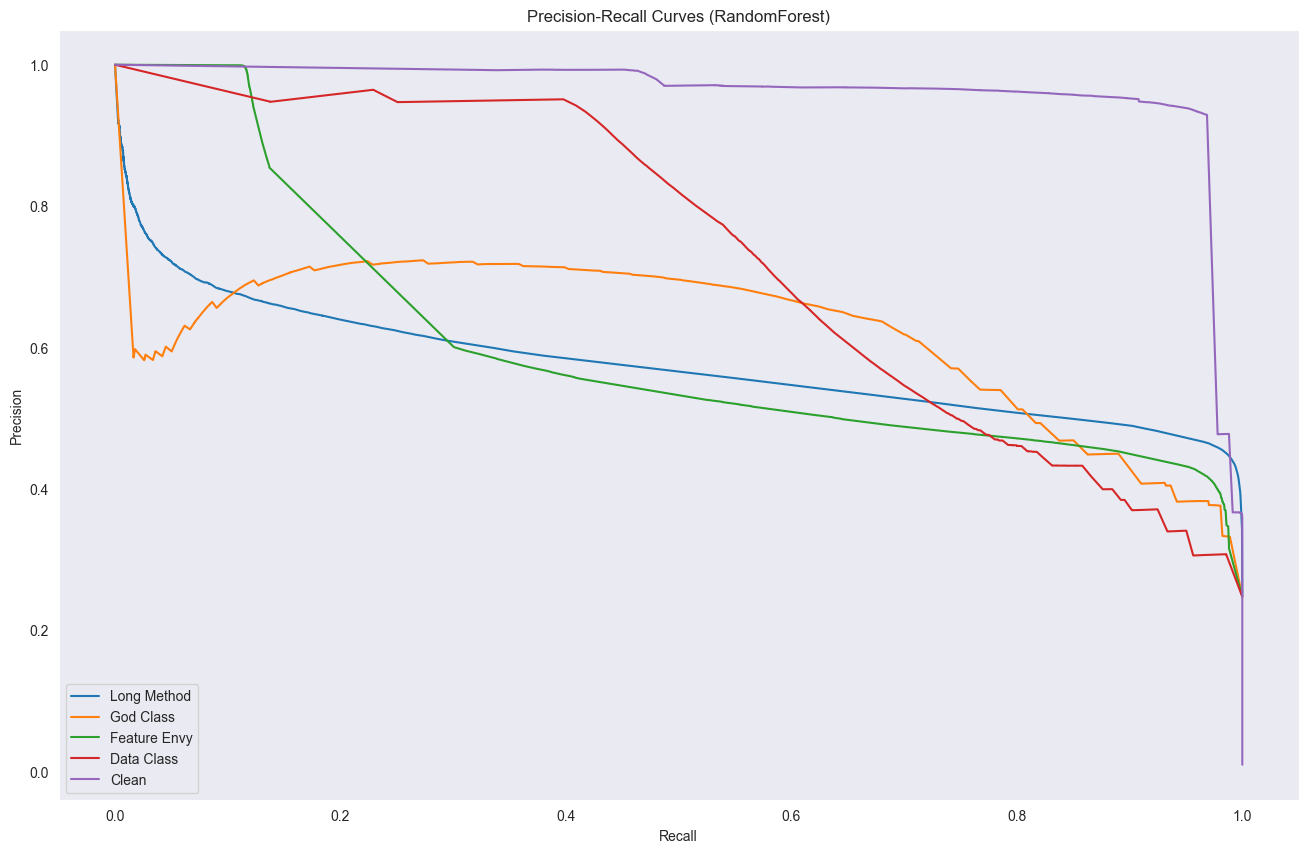

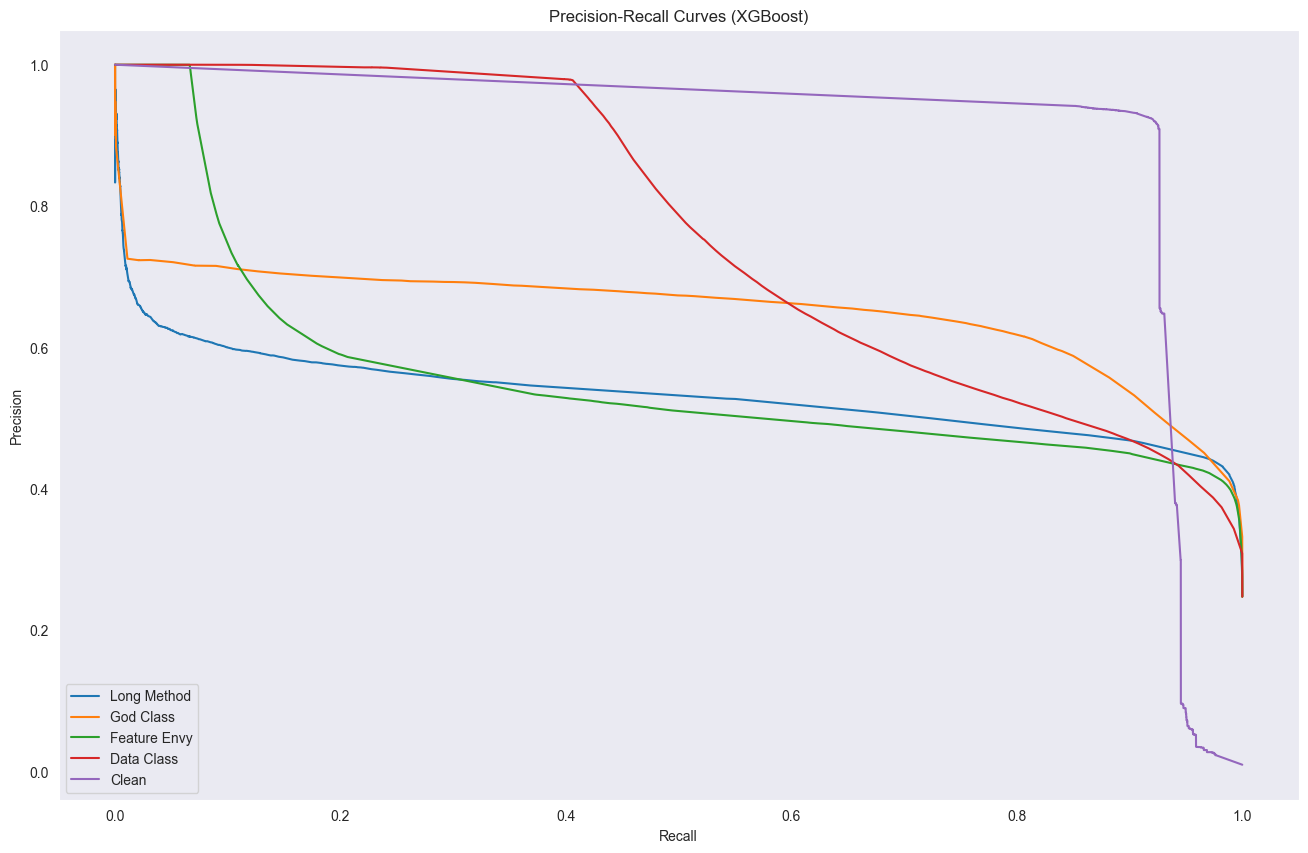

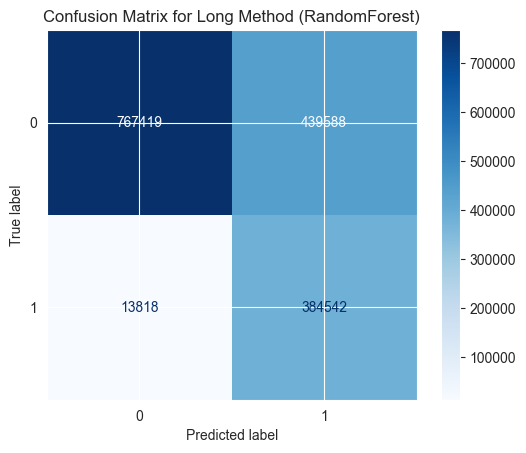

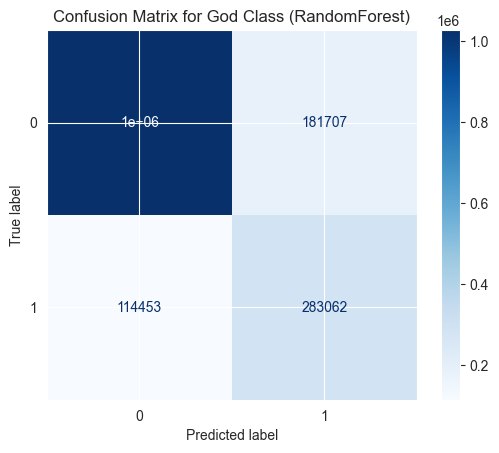

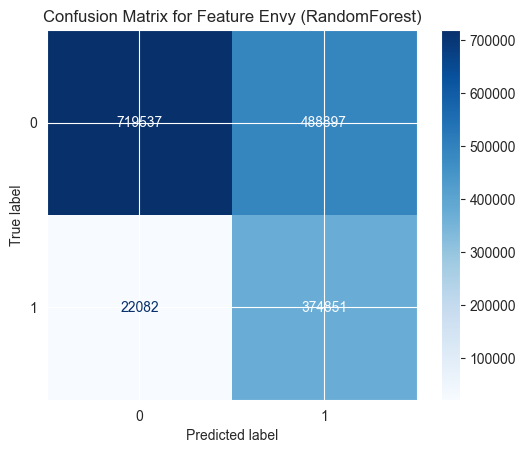

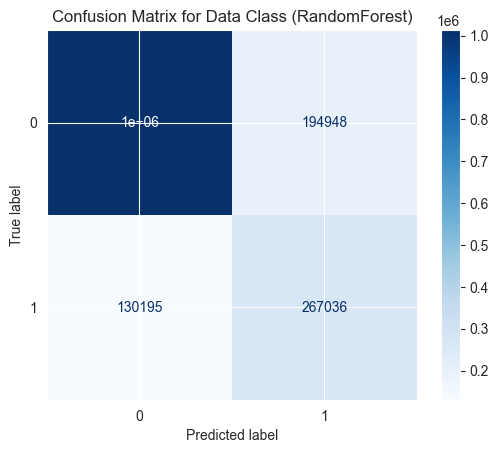

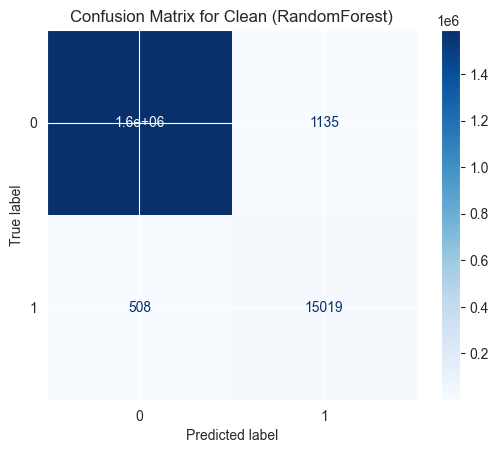

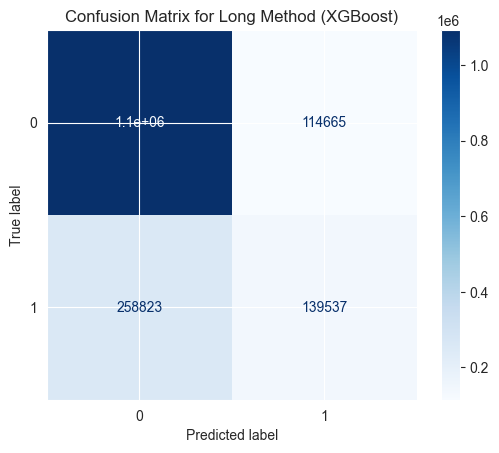

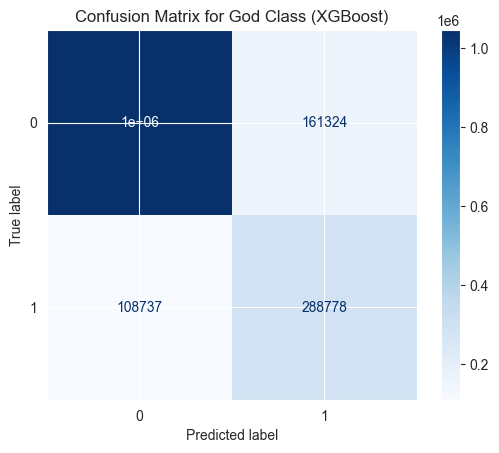

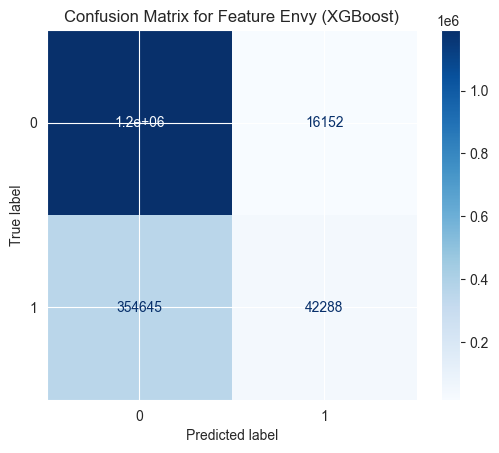

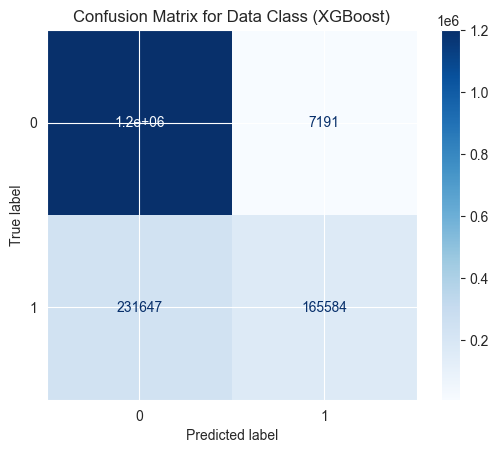

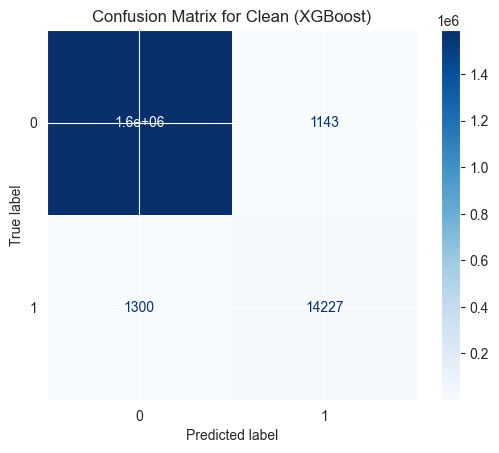

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns

# Predict probabilities and binary predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)

# y_proba_rf and y_proba_xgb are list of arrays, one per label
# Convert them to 2D array: shape (n_samples, n_classes)
y_proba_rf = np.array([proba[:, 1] for proba in y_proba_rf]).T
y_proba_xgb = np.array([proba[:, 1] for proba in y_proba_xgb]).T

# Extract label names
labels = y_test.columns.tolist()

def plot_pr_curves(y_true, y_proba, model_name):
    plt.figure(figsize=(16, 10))
    for i, label in enumerate(labels):
        precision, recall, _ = precision_recall_curve(y_true.iloc[:, i], y_proba[:, i])
        plt.plot(recall, precision, label=f'{label}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves ({model_name})')
    plt.legend()
    plt.grid()
    plt.show()

plot_pr_curves(y_test, y_proba_rf, "RandomForest")
plot_pr_curves(y_test, y_proba_xgb, "XGBoost")

def plot_confusion_matrices(y_true, y_pred, model_name):
    for i, label in enumerate(labels):
        cm = confusion_matrix(y_true.iloc[:, i], y_pred[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix for {label} ({model_name})')
        plt.show()

plot_confusion_matrices(y_test, y_pred_rf, "RandomForest")
plot_confusion_matrices(y_test, y_pred_xgb, "XGBoost")

### Precision-Recall Curves

To further evaluate the trade-off between **precision** and **recall** for each class label, we plotted **Precision-Recall (PR) curves** for both classical models.

These curves offer a visual summary of how well the model balances false positives and false negatives across different decision thresholds.

#### Random Forest

![Random Forest PR Curves](../data/images/pr-recall-rf.png)

- The **Clean** label achieves nearly perfect precision and recall across thresholds.
- **Feature Envy** and **Long Method** exhibit steep drops in precision as recall increases, indicating **difficulty distinguishing** these smells using only metric-based features.
- Curves for **God Class** and **Data Class** are more balanced but still show a gradual decline, reflecting moderate separability.

#### XGBoost

![XGBoost PR Curves](../data/images/pr-recall-xgb.png)

- XGBoost produces **flatter PR curves** for most labels, especially *Long Method* and *Feature Envy* — highlighting **low recall but improved precision** over Random Forest.
- **Clean** again shows a strong, stable curve.
- The **Data Class** curve indicates good precision up to a certain recall threshold, then drops steeply.

---

**Summary**:
- These visualizations confirm the **limitations of classical models** in detecting more **semantic smells** like *Feature Envy* and *Long Method*.
- They also support the conclusion that **metric-based features alone are not sufficient** to robustly detect all code smells.
- In the next stage, transformer models will be trained to determine whether they can improve these curves by leveraging **contextual and structural code features**.

## Model Evaluation Summary

This section summarizes the evaluation of the two classical machine learning models — **Random Forest** and **XGBoost** — trained on the merged dataset combining *SmellyCode++* and *CSQA* samples.

---

### Evaluation Goal

The purpose of evaluating classical models is not to optimize them to the fullest extent, but to establish a **baseline performance** for detecting code smells using only **metric-based features**.

This baseline serves as a comparison point for transformer-based models trained on raw source code.

> **Research Hypothesis**:
> Transformer models pre-trained on source code can outperform classical models by learning the **semantic and structural context** of code smells, rather than relying solely on handcrafted metrics.

---

### Random Forest: Evaluation Metrics

| Code Smell     | Precision | Recall | F1-score | Support   |
|----------------|-----------|--------|----------|-----------|
| Long Method    | 0.47      | 0.97   | 0.63     | 398,360   |
| God Class      | 0.61      | 0.71   | 0.66     | 397,515   |
| Feature Envy   | 0.43      | 0.94   | 0.59     | 396,933   |
| Data Class     | 0.58      | 0.67   | 0.62     | 397,231   |
| Clean          | 0.93      | 0.97   | 0.95     | 15,527    |

- **Hamming Loss**: 0.1978
- **Subset Accuracy (Exact Match)**: 29.47%

**Observations**:
- High recall across most smells indicates the model **overpredicts** positives.
- Especially effective in identifying *Clean* classes.
- Susceptible to **false positives** for complex smells (*Feature Envy*, *Long Method*).

---

### ⚡ XGBoost: Evaluation Metrics

| Code Smell     | Precision | Recall | F1-score | Support   |
|----------------|-----------|--------|----------|-----------|
| Long Method    | 0.55      | 0.35   | 0.43     | 398,360   |
| God Class      | 0.64      | 0.73   | 0.68     | 397,515   |
| Feature Envy   | 0.72      | 0.11   | 0.19     | 396,933   |
| Data Class     | 0.96      | 0.42   | 0.58     | 397,231   |
| Clean          | 0.93      | 0.92   | 0.92     | 15,527    |

- **Hamming Loss**: 0.1564
- **Subset Accuracy (Exact Match)**: 39.75%

**Observations**:
- Higher **precision** than Random Forest, especially for *Data Class* and *Clean*.
- Still suffers from **very low recall** for *Feature Envy*, limiting its F1-score.
- Performs better in avoiding false positives but **misses many positives**.

---

### Key Insights

- Both models detect **Clean** code with high precision and recall due to strong class imbalance.
- Semantic smells (*Long Method*, *Feature Envy*) are **challenging** to detect using only structural metrics.
- Random Forest emphasizes **recall**, XGBoost leans towards **precision**.
- These trade-offs underscore the **limits of metric-based detection**, making the case for **transformer-based approaches** that can better capture context and intent.

---

Next, we will evaluate transformer models (e.g., CodeBERT, GraphCodeBERT) to explore whether **contextual embeddings and semantic understanding** can improve detection performance across code smell classes.